# Cross-Lingual Word Embedding Alignment

## Setup

In [1]:
!pip install fasttext

In [2]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 59.5 MB/s eta 0:00:00:00:0100:01


## Libraries

In [3]:
import numpy as np
import fasttext
from fasttext import util
import torch
import torch.nn as nn
import torch.optim as optim
import faiss
import matplotlib.pyplot as plt
from numpy.linalg import svd
import os
import matplotlib.animation as animation
from IPython.display import HTML
from sklearn.manifold import TSNE

### Fasttext Monolingual Embeddings

In [7]:

# # English
# fasttext.util.download_model('en', if_exists='ignore')  # English

# # Hindi
# fasttext.util.download_model('hi', if_exists='ignore')  # Hindi


### MUSE bilingual dictionary

In [8]:

# # train dataset
# !wget https://dl.fbaipublicfiles.com/arrival/dictionaries/en-hi.0-5000.txt

# # test dataset
# !wget https://dl.fbaipublicfiles.com/arrival/dictionaries/en-hi.5000-6500.txt


### Filter monolingual embeddings

In [9]:

# eng_embed_path = "data_path/cc.en.300.bin"
# hindi_embed_path = "data_path/cc.hi.300.bin"

# top_n_words = 100000

# eng_embed = fasttext.load_model(eng_embed_path)
# hindi_embed = fasttext.load_model(hindi_embed_path)

# eng_all_words = eng_embed.get_words()
# hindi_all_words = hindi_embed.get_words()

# print(f"Total words in English: {len(eng_all_words)}")
# print(f"Total words in Hindi: {len(hindi_all_words)}")

# num_words_to_keep_eng = min(top_n_words, len(eng_all_words))
# num_words_to_keep_hindi = min(top_n_words, len(hindi_all_words))
# print(f"Selecting top {num_words_to_keep_eng} words...")

# top_words_eng = eng_all_words[:num_words_to_keep_eng]
# top_words_hindi = hindi_all_words[:num_words_to_keep_hindi]

# filtered_eng_embed = {}
# filtered_hindi_embed = {}

# for word in top_words_eng:
#     filtered_eng_embed[word] = eng_embed.get_word_vector(word)

# for word in top_words_hindi:
#     filtered_hindi_embed[word] = hindi_embed.get_word_vector(word)

# print(f"Successfully extracted {len(filtered_eng_embed)} English words and their vectors.")
# print(f"Successfully extracted {len(filtered_hindi_embed)} Hindi words and their vectors.")

# if filtered_eng_embed and filtered_hindi_embed:
#     print("Saving filtered embeddings...")
#     # Save English embeddings
#     np.savez_compressed("/home/spring2024/sk4858/ashu1069/filtered_eng_embeddings.npz", eng=filtered_eng_embed)
#     print("English embeddings saved successfully.")
    
#     # Save Hindi embeddings
#     np.savez_compressed("/home/spring2024/sk4858/ashu1069/filtered_hindi_embeddings.npz", hi=filtered_hindi_embed)
#     print("Hindi embeddings saved successfully.")
# else:
#     print("No embeddings were extracted. Exiting.")


In [10]:
bilingual_train_dict_path = "/kaggle/input/word-alignment/sarvam/en-hi.5000-6500.txt"

# Load filtered embeddings
eng_data = np.load("/kaggle/input/word-alignment/sarvam/filtered_eng_embeddings.npz", allow_pickle=True)
hindi_data = np.load("/kaggle/input/word-alignment/sarvam/filtered_hindi_embeddings.npz", allow_pickle=True)

eng_dict = eng_data['eng'].item()
hindi_dict = hindi_data['hi'].item()

print(f'English: {len(eng_dict)}')
print(f'Hindi: {len(hindi_dict)}')

English: 100000
Hindi: 100000


## Supervised Alignment

In [11]:
def load_bilingual_dict(filepath):
  pairs = []
  with open(filepath, 'r', encoding = 'utf-8') as f:
    for line in f:
      parts = line.strip().split()
      if len(parts) == 2:
        pairs.append((parts[0], parts[1]))
  print(f"Total number of word pairs loaded: {len(pairs)}")
  return pairs

def prepare_alignment_matrices(pairs, src_embeds, target_embeds):
  X, Y = [], []
  for src_word, target_word in pairs:
    if src_word in src_embeds and target_word in target_embeds:
      X.append(src_embeds[src_word])
      Y.append(target_embeds[target_word])
  X, Y = np.array(X, dtype=np.float32), np.array(Y, dtype=np.float32)
  print(f"Number of valid pairs: {len(X)}")

  # Normalize the vectors
  X_norm = X / np.linalg.norm(X, axis=1, keepdims=True)
  Y_norm = Y / np.linalg.norm(Y, axis=1, keepdims=True)

  return X_norm, Y_norm

def procrustes_algorithm(X, Y):
  '''
  We have two matrices, X (a reference matrix) and Y (matrix we need to align) or it can be vice versa.
  Dimensions of X & Y: [number of words, dimension of the vector embeddings]
  Y' = s*Y*R + T, where R is rotation matrix, T is translation matrix, and s is scale (optional).

  1. Center the data around the mean of the data
  2. Normalize the scale
  3. Use SVD on X^T.Y to find R
  4. Apply rotation & scaling by Y
  '''
  # apply singular value decomposition
  U, _, Vt = np.linalg.svd(X.T @ Y)
  W = U @ Vt
  print(f'Transformation matrix shape: {W.shape}')
  return W

In [12]:
pairs = load_bilingual_dict(bilingual_train_dict_path)
X_norm, Y_norm = prepare_alignment_matrices(pairs, eng_dict, hindi_dict)

W_supervised = procrustes_algorithm(X_norm, Y_norm)
print(f'Shape of the transformation matrix: {W_supervised.shape}')

Total number of word pairs loaded: 2032
Number of valid pairs: 1600
Transformation matrix shape: (300, 300)
Shape of the transformation matrix: (300, 300)


## Unsupervised Alignment

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [14]:
eng_words = list(eng_dict.keys())
hindi_words = list(hindi_dict.keys())

In [15]:
# Indexing of english words
word2idx_eng = {word: idx for idx, word in enumerate(eng_words)}
idx2word_eng = {idx: word for word, idx in word2idx_eng.items()}

# Indexing of hindi words
word2idx_hi = {word: idx for idx, word in enumerate(hindi_words)}
idx2word_hi = {idx: word for word, idx in word2idx_hi.items()}

In [16]:
# Prepare data for training
X_src = np.vstack([hindi_dict[word] for word in hindi_words])
Y_target = np.vstack([eng_dict[word] for word in eng_words])

# Normalize the training data
X_src_norm = X_src / np.linalg.norm(X_src, axis=1, keepdims=True)
Y_target_norm = Y_target / np.linalg.norm(Y_target, axis=1, keepdims=True)

# converting to tensors
X_src_norm_tensor = torch.tensor(X_src_norm[:50000], dtype=torch.float32).to(device)
Y_target_norm_tensor = torch.tensor(Y_target_norm[:50000], dtype=torch.float32).to(device)
print(f"Shape of X_src_norm_tensor: {X_src_norm_tensor.shape}")
print(f"Shape of Y_target_norm_tensor: {Y_target_norm_tensor.shape}")

Shape of X_src_norm_tensor: torch.Size([50000, 300])
Shape of Y_target_norm_tensor: torch.Size([50000, 300])


In [17]:
class Discriminator(nn.Module):
  '''
  From the paper (https://arxiv.org/pdf/1710.04087): For our discriminator, we
  use a multilayer perceptron with two hidden layers of size 2048, and
  Leaky-ReLU activation functions. The input to the discriminator is corrupted
  with dropout noise with a rate of 0.1. As suggested by Goodfellow (2016),
  we include a smoothing coefficient s = 0.2 in the discriminator predictions.
  We use stochastic gradient descent with a batch size of 32, a learning rate of
  0.1 and a decay of 0.95 both for the discriminator and W. We divide the
  learning rate by 2 every time our unsupervised validation criterion decreases
  '''
  def __init__(self, input_dim, dropout_rate=0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout_rate)
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 2048),
            nn.LeakyReLU(0.2),
            nn.Linear(2048, 2048),
            nn.LeakyReLU(0.2),
            nn.Linear(2048, 1),
            nn.Sigmoid()
        )

  def forward(self, x):
        x = self.dropout(x)
        return self.mlp(x)

In [18]:
input_dim = 300
W = nn.Linear(input_dim, input_dim, bias=False).to(device)
D = Discriminator(input_dim).to(device)
initial_lr = 0.1
optimizer_W = optim.SGD(W.parameters(), lr=initial_lr)
optimizer_D = optim.SGD(D.parameters(), lr=initial_lr)

# Learning rate scheduler (exponential decay with factor 0.95)
scheduler_W = optim.lr_scheduler.ExponentialLR(optimizer_W, gamma=0.95)
scheduler_D = optim.lr_scheduler.ExponentialLR(optimizer_D, gamma=0.95)

### Adversarial Training

In [33]:
batch_size = 32
num_epochs = 15
warmup_epochs = 5
beta = 0.01

In [35]:
for epoch in range(num_epochs):
    total_loss_D = 0.0
    total_loss_W = 0.0
    num_batches = 0

    for i in range(0, X_src_norm_tensor.size(0), batch_size):
        x_batch = X_src_norm_tensor[i:i+batch_size]
        y_batch = Y_target_norm_tensor[i:i+batch_size]
        num_batches += 1

        if epoch >= warmup_epochs:
            optimizer_D.zero_grad()
            loss_D = -torch.mean(torch.log(D(W(x_batch)) + 1e-9) + torch.log(1 - D(y_batch) + 1e-9))
            loss_D.backward()
            optimizer_D.step()
            total_loss_D += loss_D.item()

        optimizer_W.zero_grad()
        loss_W = -torch.mean(torch.log(D(y_batch) + 1e-9) + torch.log(1 - D(W(x_batch)) + 1e-9))
        loss_W.backward()
        torch.nn.utils.clip_grad_norm_(W.parameters(), 1.0)
        optimizer_W.step()
        total_loss_W += loss_W.item()

        with torch.no_grad():
            W.weight.data = (1 + beta) * W.weight.data - beta * W.weight.data @ W.weight.data.T @ W.weight.data

    avg_loss_D = total_loss_D / num_batches if epoch >= warmup_epochs else 0.0
    avg_loss_W = total_loss_W / num_batches
    print(f"Epoch {epoch+1}/{num_epochs} - Discriminator Loss: {avg_loss_D:.4f}, Mapping Loss: {avg_loss_W:.4f}")


Epoch 1/15 - Discriminator Loss: 0.0000, Mapping Loss: 5.8414
Epoch 2/15 - Discriminator Loss: 0.0000, Mapping Loss: 5.8376
Epoch 3/15 - Discriminator Loss: 0.0000, Mapping Loss: 5.8382
Epoch 4/15 - Discriminator Loss: 0.0000, Mapping Loss: 5.8403
Epoch 5/15 - Discriminator Loss: 0.0000, Mapping Loss: 5.8372
Epoch 6/15 - Discriminator Loss: 0.3741, Mapping Loss: 9.4581
Epoch 7/15 - Discriminator Loss: 0.2891, Mapping Loss: 9.6286
Epoch 8/15 - Discriminator Loss: 0.2968, Mapping Loss: 9.6274
Epoch 9/15 - Discriminator Loss: 0.2769, Mapping Loss: 10.0518
Epoch 10/15 - Discriminator Loss: 0.2725, Mapping Loss: 10.5009
Epoch 11/15 - Discriminator Loss: 0.2482, Mapping Loss: 11.0023
Epoch 12/15 - Discriminator Loss: 0.2495, Mapping Loss: 11.3388
Epoch 13/15 - Discriminator Loss: 0.2382, Mapping Loss: 11.4944
Epoch 14/15 - Discriminator Loss: 0.2072, Mapping Loss: 12.0493
Epoch 15/15 - Discriminator Loss: 0.2304, Mapping Loss: 11.9850


Initially, mapped embeddings are poor → discriminator learns too easily, so I froze the discriminator for 2 epochs, known as warm start, and also used gradient clipping to avoid gradient divergence.

`sklearn` `NearestNeighbors` is slow if the vocab size is very large. So, I decided to use FAISS, a library for efficient similarity search and clustering of dense vectors by Meta

For CSLS, the scores are computed all at once, leadning to high memory usage → splitted into mini-batches

In [36]:
def knn_faiss(x, y, k):
    index = faiss.IndexFlatIP(y.shape[1])
    index.add(y.astype('float32'))
    sims, idxs = index.search(x.astype('float32'), k)
    return sims, idxs

def csls_faiss(W_src, target, k=10, batch_size=1024):
    sims_src, _ = knn_faiss(W_src, target, k)
    r_T = np.mean(sims_src, axis=1)

    sims_target, _ = knn_faiss(target, W_src, k)
    r_S = np.mean(sims_target, axis=1)

    csls_all = []
    for i in range(0, len(W_src), batch_size):
        sub = W_src[i:i+batch_size]
        sim = np.dot(sub, target.T)
        csls = 2 * sim - r_T[i:i+batch_size][:, None] - r_S[None, :]
        csls_all.append(csls)
    return np.vstack(csls_all)

In [37]:
W_src_np = W(X_src_norm_tensor).detach().cpu().numpy()
target_np = Y_target_norm_tensor.detach().cpu().numpy()
csls_scores = csls_faiss(W_src_np, target_np)

In [38]:
src_to_target = np.argmax(csls_scores, axis=1)
target_to_src = np.argmax(csls_scores, axis=0)
mutual_nn = [(i, j) for i, j in enumerate(src_to_target) if target_to_src[j] == i]
print(f"Mutual nearest neighbors found: {len(mutual_nn)} pairs")

Mutual nearest neighbors found: 17421 pairs


In [39]:
X_dict = X_src_norm_tensor[[i for i, _ in mutual_nn]].cpu().numpy().T
Y_dict = Y_target_norm_tensor[[j for _, j in mutual_nn]].cpu().numpy().T
U, _, Vt = svd(Y_dict @ X_dict.T)
W_refined = torch.tensor(U @ Vt, dtype=torch.float32).to(device)

## t-SNE Visualization of Aligned Embeddings

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2375 (\N{DEVANAGARI VOWEL SIGN E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2342 (\N{DEVANAGARI LETTER DA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2379 (\N{DEVANAGARI VOWEL SIGN O}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/

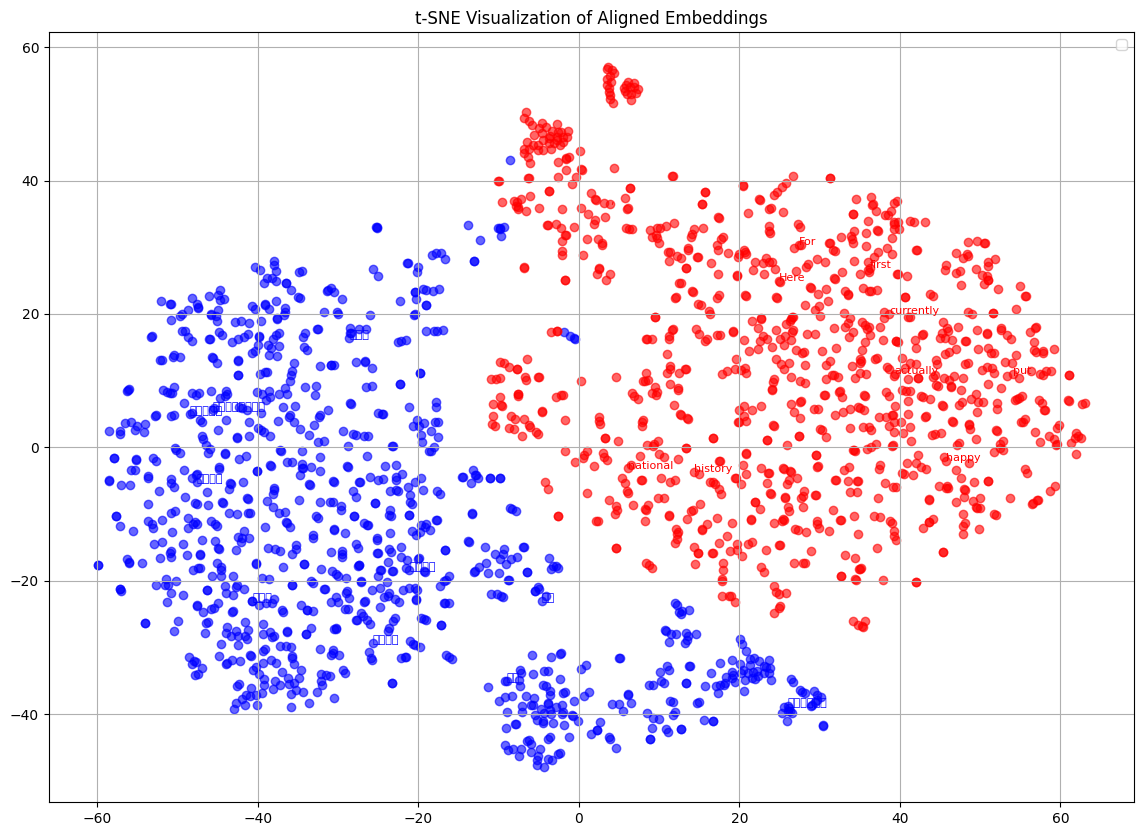

In [40]:
num_points = 1000
aligned_hi = (W_refined @ X_src_norm_tensor[:num_points].T).T.detach().cpu().numpy()
aligned_en = Y_target_norm_tensor[:num_points].detach().cpu().numpy()

labels = ["hi"] * num_points + ["en"] * num_points
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
reduced = tsne.fit_transform(np.vstack([aligned_hi, aligned_en]))

plt.figure(figsize=(14, 10))
for i in range(num_points):
    plt.scatter(reduced[i, 0], reduced[i, 1], c='blue', alpha=0.6)
    if i % 100 == 0:
        plt.text(reduced[i, 0], reduced[i, 1], idx2word_hi[i], fontsize=8, color='blue')
for i in range(num_points):
    plt.scatter(reduced[num_points + i, 0], reduced[num_points + i, 1], c='red', alpha=0.6)
    if i % 100 == 0:
        plt.text(reduced[num_points + i, 0], reduced[num_points + i, 1], idx2word_eng[i], fontsize=8, color='red')
plt.title("t-SNE Visualization of Aligned Embeddings")
plt.legend()
plt.grid(True)
plt.show()

## Evaluation & Comparison of Supervised vs Unsupervised Alignment

In [41]:
print("Evaluating both supervised and unsupervised alignments...")
bilingual_test_dict_path = "/kaggle/input/word-alignment/sarvam/en-hi.5000-6500.txt"

test_pairs = load_bilingual_dict(bilingual_test_dict_path)
X_eval = np.vstack([eng_dict[w1] for w1, w2 in test_pairs if w1 in eng_dict and w2 in hindi_dict])
Y_eval = np.vstack([hindi_dict[w2] for w1, w2 in test_pairs if w1 in eng_dict and w2 in hindi_dict])
eval_pairs = [(w1, w2) for w1, w2 in test_pairs if w1 in eng_dict and w2 in hindi_dict]

Evaluating both supervised and unsupervised alignments...
Total number of word pairs loaded: 2032


In [42]:
word2idx_eval_src = {word: idx for idx, (word, _) in enumerate(eval_pairs)}
word2idx_eval_target = {word: idx for idx, (_, word) in enumerate(eval_pairs)}

### Cosine Similarity Analysis

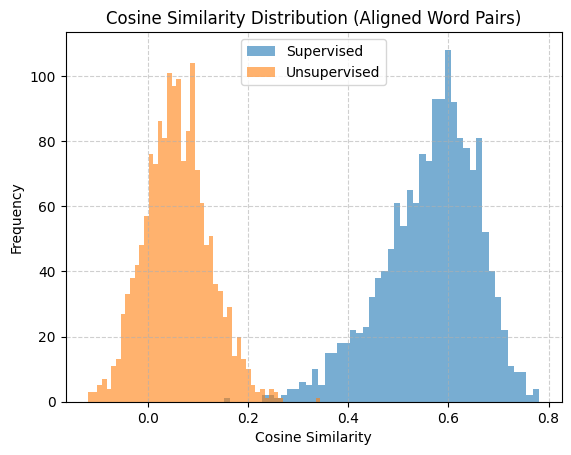

In [43]:
def analyze_cosine_similarity(W_map, X_test, Y_test, pairs):
    X_proj = (X_test @ W_map).astype(np.float32)
    X_proj = X_proj / np.linalg.norm(X_proj, axis=1, keepdims=True)
    Y_test = Y_test / np.linalg.norm(Y_test, axis=1, keepdims=True)
    similarities = np.sum(X_proj * Y_test, axis=1)
    return similarities

cos_sim_sup = analyze_cosine_similarity(W_supervised, X_eval, Y_eval, eval_pairs)
cos_sim_unsup = analyze_cosine_similarity(W_refined.cpu().numpy(), X_eval, Y_eval, eval_pairs)

plt.hist(cos_sim_sup, bins=50, alpha=0.6, label='Supervised')
plt.hist(cos_sim_unsup, bins=50, alpha=0.6, label='Unsupervised')
plt.title('Cosine Similarity Distribution (Aligned Word Pairs)')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [44]:
def evaluate_alignment(W_map, X_test, Y_test, test_pairs, word2idx_src, word2idx_target, top_k=(1, 5)):
    X_proj = (X_test @ W_map).astype(np.float32)
    X_proj = X_proj / np.linalg.norm(X_proj, axis=1, keepdims=True)
    Y_test = Y_test / np.linalg.norm(Y_test, axis=1, keepdims=True)
    sims = X_proj @ Y_test.T
    results = {}
    for k in top_k:
        correct = 0
        for i, (src_word, target_word) in enumerate(test_pairs):
            if src_word in word2idx_src and target_word in word2idx_target:
                src_idx = word2idx_src[src_word]
                target_idx = word2idx_target[target_word]
                pred_top_k = np.argsort(-sims[src_idx])[:k]
                if target_idx in pred_top_k:
                    correct += 1
        results[f"P@{k}"] = correct / len(test_pairs)
    return results

### Ablation Study on Dictionary Sizes

In [45]:
def ablation_study_alignment(pairs, embed_src, embed_tgt, sizes=[5000, 10000, 20000]):
    results = {}
    for size in sizes:
        subset = pairs[:size]
        X_sub, Y_sub = prepare_alignment_matrices(subset, embed_src, embed_tgt)
        W_ablate = procrustes_algorithm(X_sub, Y_sub)

        eval_subset = [(w1, w2) for w1, w2 in test_pairs if w1 in embed_src and w2 in embed_tgt]
        X_eval_sub = np.vstack([embed_src[w1] for w1, w2 in eval_subset])
        Y_eval_sub = np.vstack([embed_tgt[w2] for w1, w2 in eval_subset])
        word2idx_src = {word: idx for idx, (word, _) in enumerate(eval_subset)}
        word2idx_tgt = {word: idx for idx, (_, word) in enumerate(eval_subset)}

        scores = evaluate_alignment(W_ablate, X_eval_sub, Y_eval_sub, eval_subset, word2idx_src, word2idx_tgt)
        results[f'{size} pairs'] = scores
    return results

ablation_results = ablation_study_alignment(pairs, eng_dict, hindi_dict)

print("--- Ablation Study Results ---")
for size, res in ablation_results.items():
    print(f"{size}: {res}")

Number of valid pairs: 1600
Transformation matrix shape: (300, 300)
Number of valid pairs: 1600
Transformation matrix shape: (300, 300)
Number of valid pairs: 1600
Transformation matrix shape: (300, 300)
--- Ablation Study Results ---
5000 pairs: {'P@1': 0.66125, 'P@5': 0.9775}
10000 pairs: {'P@1': 0.66125, 'P@5': 0.9775}
20000 pairs: {'P@1': 0.66125, 'P@5': 0.9775}


In [46]:
results_supervised = evaluate_alignment(W_supervised, X_eval, Y_eval, eval_pairs, word2idx_eval_src, word2idx_eval_target)
results_unsupervised = evaluate_alignment(W_refined.cpu().numpy(), X_eval, Y_eval, eval_pairs, word2idx_eval_src, word2idx_eval_target)

Evaluation Results
Supervised Procrustes: {'P@1': 0.66125, 'P@5': 0.9775}
Unsupervised (Adv + CSLS + Refinement): {'P@1': 0.00125, 'P@5': 0.006875}


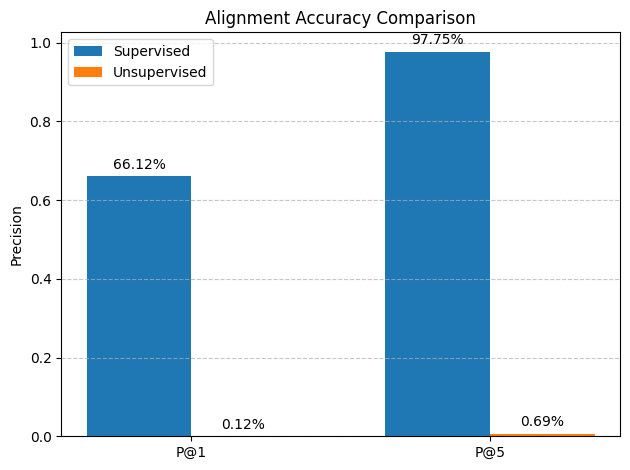

In [49]:
print("Evaluation Results")
print("Supervised Procrustes:", results_supervised)
print("Unsupervised (Adv + CSLS + Refinement):", results_unsupervised)

# Comparison Bar Chart
labels = ['P@1', 'P@5']
sup_scores = [results_supervised['P@1'], results_supervised['P@5']]
unsup_scores = [results_unsupervised['P@1'], results_unsupervised['P@5']]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, sup_scores, width, label='Supervised')
rects2 = ax.bar(x + width/2, unsup_scores, width, label='Unsupervised')

ax.set_ylabel('Precision')
ax.set_title('Alignment Accuracy Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.2%}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
